In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from adtk.visualization import plot
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

df=pd.read_csv('cardox.csv')
df.head()

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86


In [2]:
df.isnull().sum()

date     0
value    0
dtype: int64

Text(0.5, 1.0, 'Графік часового ряду')

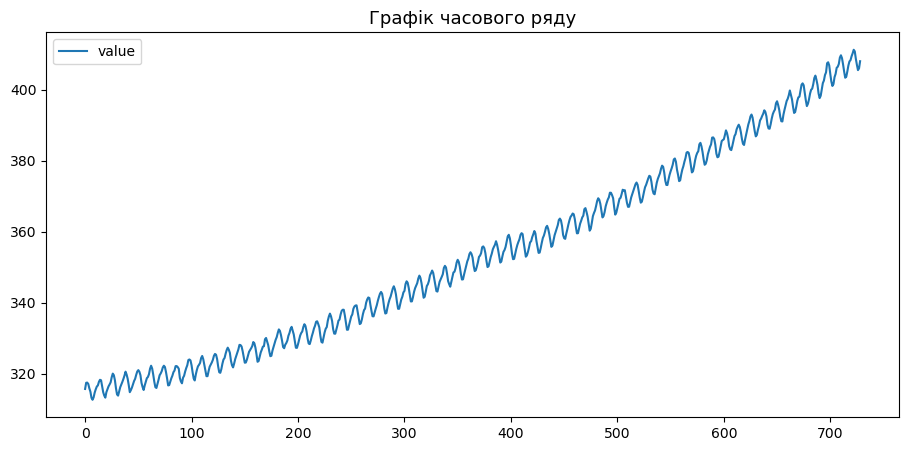

In [3]:
# Пропущених значень нема
# Намалюємо графік часового ряду

df.plot(figsize=(11, 5))
plt.title("Графік часового ряду", fontsize=13)

In [4]:
# Бачимо що є тренд, сезонність та часовий ряд не стаціонарний
# Підтвердимо що ряд не стаціонарний

df.index = pd.to_datetime(df['date'])
del df['date']
df.index.freq = df.index.inferred_freq

adft = adfuller(df, autolag='AIC')
output_df = pd.DataFrame({'Values':[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], 
                                    adft[4]['5%'], adft[4]['10%']]  ,
                          "Metric":['Test Statistics','p-value','No. of lags used','Number of observations used',
                                    'critical value (1%)', 'critical value (5%)', 'critical value (10%)']})
print(output_df)

       Values                       Metric
0    4.994847              Test Statistics
1    1.000000                      p-value
2   20.000000             No. of lags used
3  708.000000  Number of observations used
4   -3.439620          critical value (1%)
5   -2.865631          critical value (5%)
6   -2.568948         critical value (10%)


date
1958-09-01    True
1958-10-01    True
1958-11-01    True
1959-09-01    True
1959-10-01    True
1960-09-01    True
1960-10-01    True
2018-05-01    True
dtype: bool

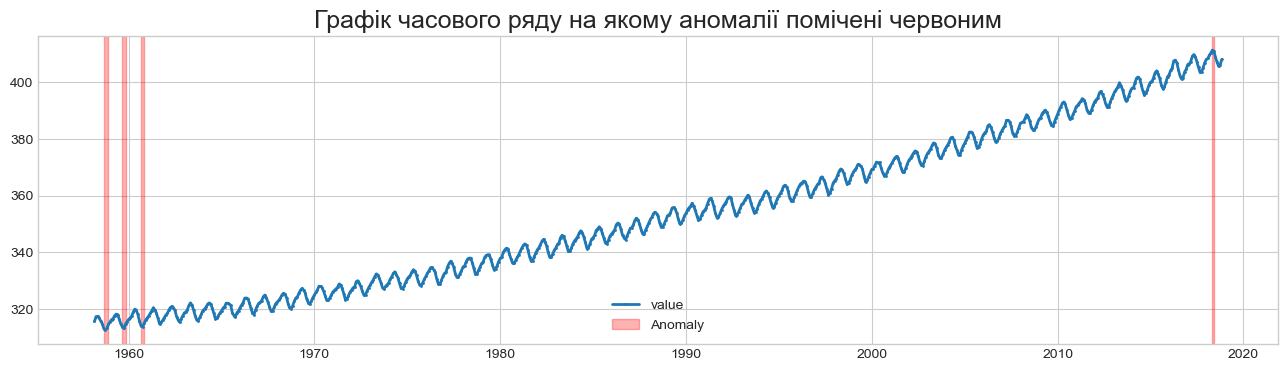

In [5]:
# Бачимо з графіка вище, що аномалій таких як викиди, всплески та зсув рівня явних немає. 
# Подивимось більш детальніше на аномалії. 

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')
plt.title("Графік часового ряду на якому аномалії помічені червоним", fontsize=18)
anomalies[anomalies]

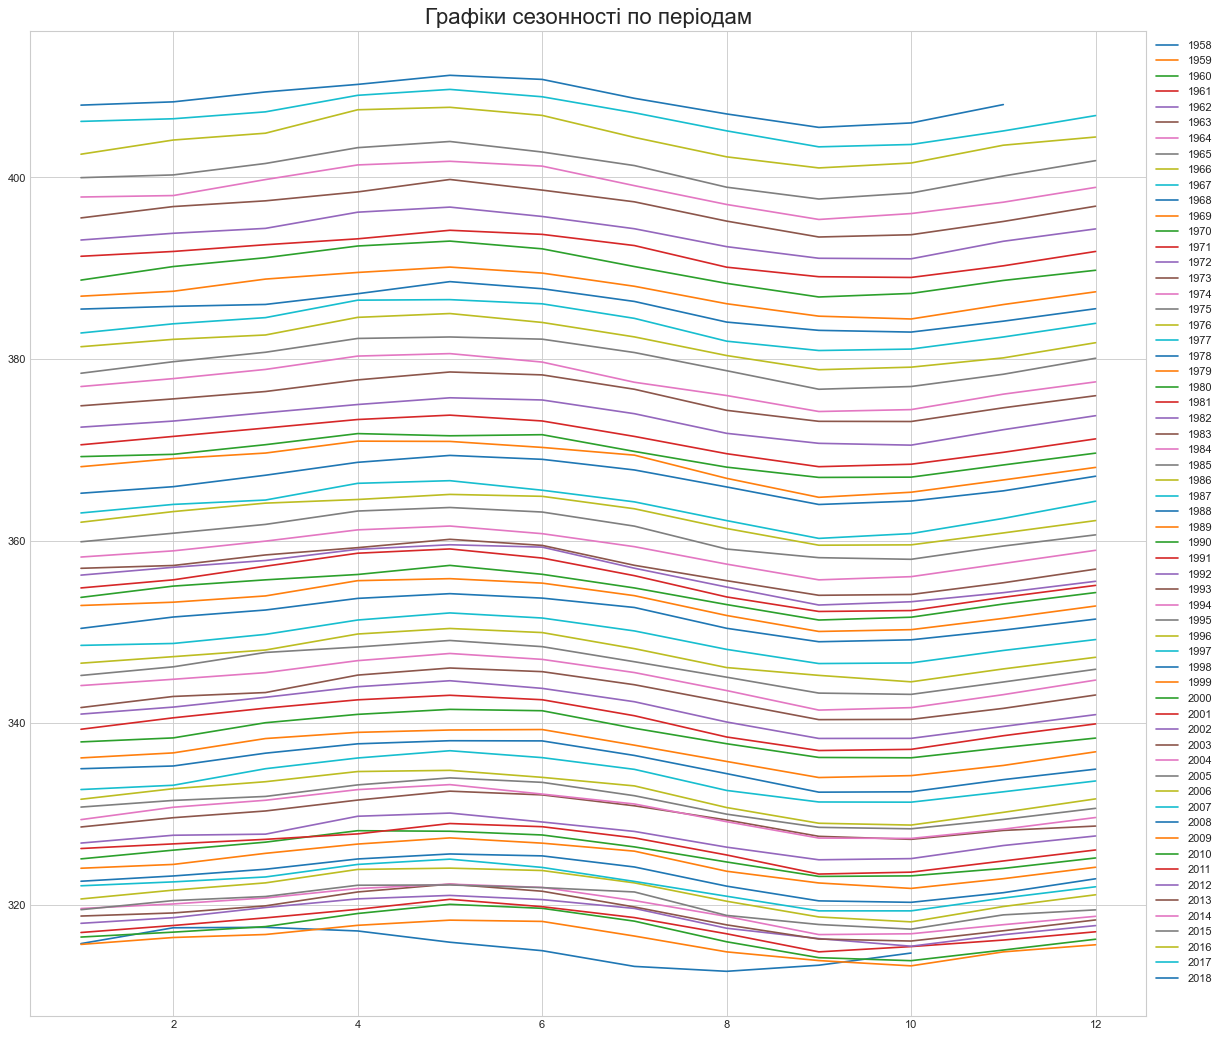

In [6]:
# Подивимось на аномалії на графіках сезонності по періодам. 

def sesonal(data, s):
    plt.figure(figsize=(18,16), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Графіки сезонності по періодам", fontsize=20)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()
    
sesonal(df,12)

In [7]:
# Бачимо що аномалії дійсно є з початку 2018р, так як це останній період, то можемо видалити ці значення

df_correct = df[:'2018-02-01']
df_correct

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2017-10-01,403.63
2017-11-01,405.12
2017-12-01,406.81


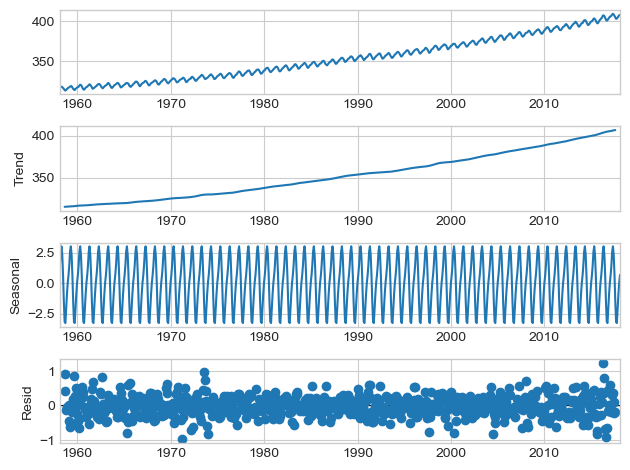

In [8]:
# Подивимось на сезонну та трендову складові

decompose = seasonal_decompose(df_correct, model='additive', period=12)
decompose.plot()
plt.show()

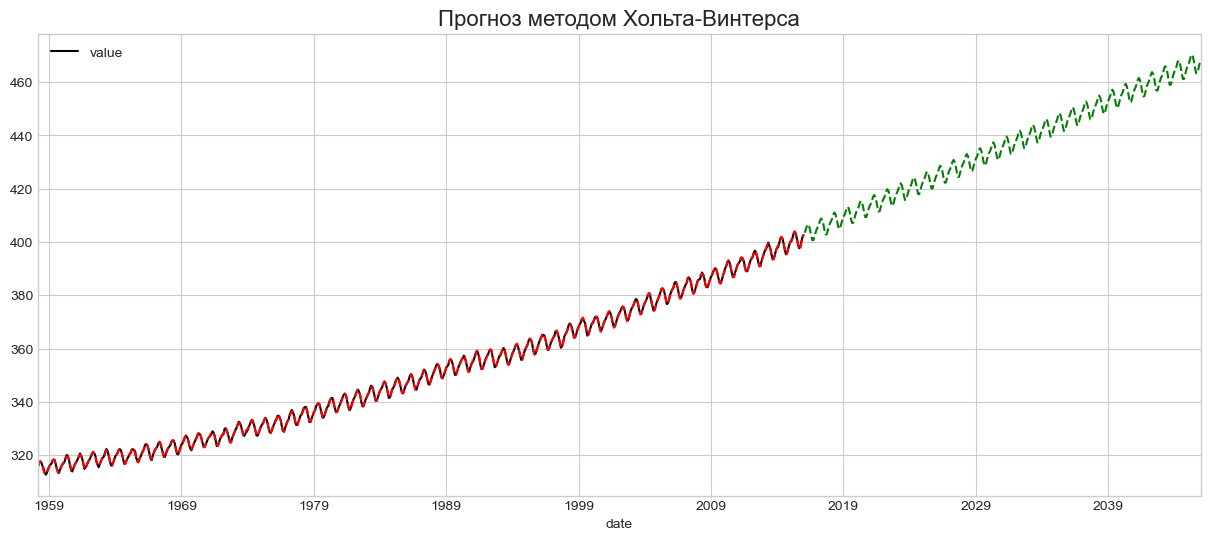

In [9]:
# Використаємо модель Хольта-Винтерса, яка може приймати дані із трендом та сезонною складовою

df_train = df_correct[:'2016-01-01']
df_test = df_correct['2016-01-01':]

model = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal='mul').fit()
model.forecast(360)
model.fittedvalues

ax = df_train.plot(figsize=(15,6), color='black')
model.fittedvalues.plot(ax=ax, style='--', color='red')
model.forecast(360).plot(ax=ax, style='--', color='green')
plt.title("Прогноз методом Хольта-Винтерса", fontsize=16)
plt.show()

In [10]:
# Оцінемо якість моделі

mae = mean_absolute_error(df_test, model.forecast(26))
mse = mean_squared_error(df_test, model.forecast(26))
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}') 

Mean Absolute Error: 1.01
Mean Squared Error: 1.66
Root Mean Squared Error: 1.29


In [11]:
# Навчимо модель на повних даних

model = ExponentialSmoothing(df_correct, seasonal_periods=12, trend='add', seasonal='mul').fit()
result_forecast = model.forecast(360)

# Збережемо результати прогнозування у файл

result_forecast.to_csv('Result_forecast.csv')